# AiDM assignment 1
## Recommender system --- Matrix factorization 

## Read data
We load the ratings data into a matrix which has 4 columns. The first column gives the user id. The second column gives the movie id. The third column gives the rating which can only be a integer from 1 to 5. The fourth column gives the timestamp in a unit of second.

In [173]:
import numpy as np
data_origin = np.genfromtxt('ml-1m/ratings.dat', delimiter= '::')

## Gradient descent
We wish to train a model of weight vectors for users and movies so that the dot product of a given user vector with a movie vector will be a prediction of the user's rating for that movie. In this way, the weights of a movie might reflect certain qualities whereas the weights of a user might reflect which qualities that particular user prefers.

First, let's randomly seperate 90% of our data into a training and 10% into a testing set in order to see if we ever start over-fitting.

In [174]:
data_copy = np.copy(data_origin)
np.random.shuffle(data_copy) # Note this only shuffles row order, individual user/movie/rate entries are the same
test_set = data_copy[0:int(len(data_copy)/10)] 
training_set = data_copy[int(len(data_copy)/10):len(data_copy)-1] 

Now we will define a training function which will train a set of user and movie vectors on a test set based on several training parameters, as well a report accuracy on a test set over the course of training.

In [175]:
def training(data, data_test, length, lrate, lamb, iterations):

    '''
    We create a list containing the unique user and movie ids, as well as a weight vectors of a 
    specified length. We will train the network so that the dot product of a given user vector 
    with a movie vector will be a prediction of the user's rating for that movie.
    '''
    
    user_list = np.unique(data[:,0])
    movie_list = np.unique(data[:,1])
    user_vector = np.random.uniform(size=(len(user_list),length))
    movie_vector = np.random.uniform(size=(len(movie_list),length))
    
    '''
    Next we create vectors of the indicies for the weights vectors for the users and movies 
    in the training and test sets. This is important since weight vectors for *unique* movies 
    is not the same as the movie id, since there some movies which have not been rated in the 
    data and it would be unhelpful to have random, unconstrained wieght vectors for movies not 
    rated in the data.
    '''
    
    user_locator = np.zeros(len(data))
    movie_locator = np.zeros(len(data))
    for i in range(len(data)):
        user_locator[i] = np.where(user_list==data[i,0])[0][0]
        movie_locator[i] = np.where(movie_list==data[i,1])[0][0]
    
    '''
    Note that some users and movies appear in the training set but not the test set, and vice versa. 
    Ratings for movies and users not in the training set will not be predicted by the model.
    '''
    
    user_locator_test = np.zeros(len(data_test))
    movie_locator_test = np.zeros(len(data_test))
    missing_user_or_movie = []
    for i in range(len(data_test)):
        try:
            user_locator_test[i] = np.where(user_list==data_test[i,0])[0][0]
            movie_locator_test[i] = np.where(movie_list==data_test[i,1])[0][0]
        except:
            missing_user_or_movie.append(i)
    print(len(missing_user_or_movie), ' movies or users in the test set are not in the training set')
    
    '''
    Next we train the weight vectors! Note that we force predictions to be between 1 and 5, 
    and include a lambda regularization factor to counteract overfitting with large weights.
    '''
    
    avg_err = np.zeros(iterations) 
    for count in range(iterations):
        for i in range(len(data)):
            '''
            Here we find the rating prediction
            ''' 
            est_rating = np.dot(user_vector[int(user_locator[i])],movie_vector[int(movie_locator[i])])
            if est_rating < 1. :
                est_rating = 1.
            if est_rating > 5. :
                est_rating = 5.   
            '''
            Here we calculate the error
            '''
            error = data[i,2] - est_rating
            '''
            Here we update the weights
            '''
            user_vector[int(user_locator[i])]  += \
            lrate * (error * movie_vector[int(movie_locator[i])] - lamb *  user_vector[int(user_locator[i])])
            movie_vector[int(movie_locator[i])] += \
            lrate * (error * user_vector[int(user_locator[i])] - lamb * movie_vector[int(movie_locator[i])])
        '''
        Here we calculate the average error in test set using updated weights
        '''
        for i in range(len(data_test)):
            if not i in missing_user_or_movie :
                est_rating = np.dot(user_vector[int(user_locator_test[i])],movie_vector[int(movie_locator_test[i])])
                if est_rating < 1. :
                    est_rating = 1.
                if est_rating > 5. :
                    est_rating = 5.
                avg_err[count] += abs(est_rating - data_test[i,2])
        avg_err[count] /= (len(data_test)-len(missing_user_or_movie))    
                 
    return user_list, user_vector, movie_list, movie_vector, avg_err

Now let us train a model with weight vectors of length 5 over 10 epochs.

In [176]:
weights, learning_rate, regularization, epochs = 5, 0.001, 0.01, 10 
users, user_weights, movies, movie_weights, avg_error = \
training(training_set, test_set, weights, learning_rate, regularization, epochs)

12  movies or users in the test set are not in the training set


Excellent, only a very small number of users and movies are unique to the test set.

Now that we have trained our model, let's take a look at how it predicts a few random entries.

In [177]:
for i in np.random.randint(len(training_set), size=5):
    print(np.dot(user_weights[int(np.where(users==training_set[i,0])[0][0])],
                 movie_weights[int(np.where(movies==training_set[i,1])[0][0])]), training_set[i,2])

3.714035022968601 2.0
3.052292209891454 1.0
4.493413729953284 5.0
4.39011760832094 3.0
4.214247852313276 5.0


Not bad! Now lets see how the accuracy of our models predicitons for the test set changed the course of fitting.

Text(0, 0.5, 'Average Error \n (Separation of Prediction from Rating)')

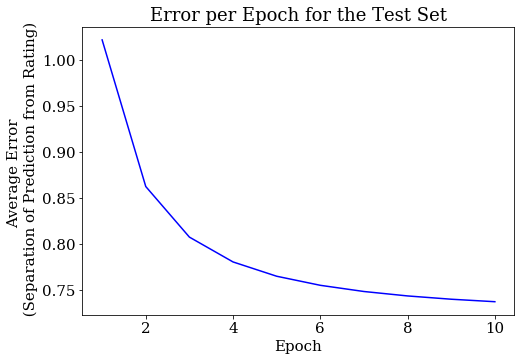

In [183]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 15
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
test, = ax.plot(range(1, epochs+1), avg_error, color = 'blue')
ax.set_title('Error per Epoch for the Test Set')
ax.set_xlabel('Epoch')
ax.set_ylabel('Average Error \n (Separation of Prediction from Rating)')

It looks like vectors of length 5 stopped significantly improving after 6 epochs. However, the test set error never increased, so our regularization parameter seems to have been sufficient. 

Let's try increasing the vector length and see if the accuracy on the test set improves - or if we are then hampered by over-fitting.

In [179]:
weights = 10 
usr10, usr_wt10, mv10, mv_wt10, err10 = training(training_set, test_set, weights, 
                                                 learning_rate, regularization, epochs)
weights = 20
usr20, usr_wt20, mv20, mv_wt20, err20 = training(training_set, test_set, weights, 
                                                 learning_rate, regularization, epochs)

12  movies or users in the test set are not in the training set
12  movies or users in the test set are not in the training set


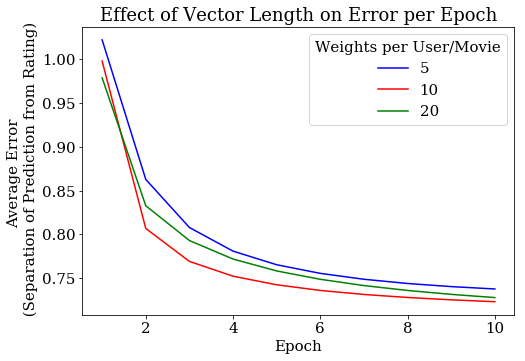

In [190]:
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
test5, = ax.plot(range(1, epochs+1), avg_error, color = 'blue', label = '5')
test10, = ax.plot(range(1, epochs+1), err_train10, color = 'red', label = '10')
test20, = ax.plot(range(1, epochs+1), err_train20, color = 'green', label = '20')
ax.set_title('Effect of Vector Length on Error per Epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('Average Error \n (Separation of Prediction from Rating)')
plt.legend(handles=[test5, test10, test20], loc=1, title='Weights per User/Movie')

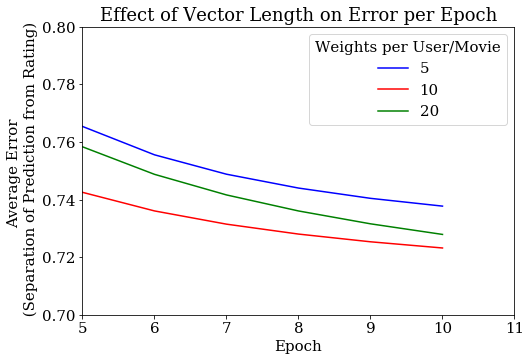

In [191]:
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.set_xlim(5,11)
ax.set_ylim(0.7,0.8)
test5, = ax.plot(range(1, epochs+1), avg_error, color = 'blue', label = '5')
test10, = ax.plot(range(1, epochs+1), err_train10, color = 'red', label = '10')
test20, = ax.plot(range(1, epochs+1), err_train20, color = 'green', label = '20')
ax.set_title('Effect of Vector Length on Error per Epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('Average Error \n (Separation of Prediction from Rating)')
plt.legend(handles=[test5, test10, test20], loc=1, title='Weights per User/Movie')

Here we see that the length 10 vector is very slightly outperforming the rest, but not by much. Keeping length 5 is sufficient. 

What about the ~10^1 movies or users in the test set lacks vectors in our model since the given movies or users were not in our training set? Well, a simple prediction would just be the global mean:

In [250]:
np.mean(data_origin[:,2])

3.581564453029317

## N Fold Cross Validation
In addition to regularization, another method to avoid overfitting is to break our data into N parts and train models for all (N-1) other parts. For each epoch, the average of the errors for all the models on their test set (the 1/N portion it was not trained on) is our error, and the average rating prediction of the models can be taken as the net prediction. 

In [238]:
def fold(data_all, N):
    '''
    Specify learning parameters and provide output containers
    '''
    weights, learning_rate, regularization, epochs = 5, 0.001, 0.01, 10
    errors, all_usrs, all_usr_weights, all_mvs, all_mv_weights = np.zeros(epochs), [], [], [], []
    '''
    Loop N times each iteration creating a training set of N-1 chuncks and a test set
    '''
    np.random.shuffle(data_all)
    for i in range(N):
        '''
        Find ith training and test sets
        '''
        data_test = data_all[int(i/N*len(data_all)):int(((i+1)/N)*len(data_all))]
        data_folder = np.delete(data_all,np.s_[int(i/N*len(data_all)):int(((i+1)/N)*len(data_all))],0)
        '''
        Train based on this N-1 chunck training set
        '''
        usr, usr_wts, mv, mv_wts, err = training(data_folder, data_test, weights,
                                                 learning_rate, regularization, epochs)
        '''
        Collect final model and sum errors
        '''
        all_usr_weights.append(usr_wts) 
        all_mv_weights.append(mv_wts)
        all_usrs.append(usr) 
        all_mvs.append(mv)
        errors = np.add(errors, err)
        
    return errors/N, all_usr_weights, all_mv_weights, all_usrs, all_mvs

Now we run our function which breaks our data into 5 portions and outputs 5 models (5 sets of user weight vectors and 5 sets of movie weight vectors), trained on different sets of 4/5 of the data, as well as the error for each model on its own test set of 1/5 of the data.

In [239]:
N = 5
crossval_avgerr, all_user_weights, all_movie_weights, all_users, all_movies = fold(data_copy, N)

28  movies or users in the test set are not in the training set
35  movies or users in the test set are not in the training set
26  movies or users in the test set are not in the training set
33  movies or users in the test set are not in the training set
32  movies or users in the test set are not in the training set


Now that we have trained our 5 models, let's take a look at how their average predictions do with a few random entries.

In [252]:
for i in np.random.randint(len(data_origin), size=10):
    pred = 0.
    '''
    Loop over the models and find the average prediction
    '''
    for j in range(N):
        '''
        Since ~10^2 movies/users will not have entries in one of the five ~10^5 sized-sets we include a 
        try statement that uses the mean upon failure
        '''
        try:
            pred += np.dot(all_user_weights[j][int(np.where(all_users[j]==data_origin[i,0])[0][0])],
                       all_movie_weights[j][int(np.where(all_movies[j]==data_origin[i,1])[0][0])])
        except:
            print('Wowza, a movie/user not in the model!')
            pred += np.mean(data_origin[:,2])
    print(pred/N, data_origin[i,2])

4.243463260978003 4.0
2.8691117255597285 4.0
3.23944941265894 3.0
3.661347371386783 4.0
3.4040944271582605 4.0
2.97142149606994 2.0
3.922081737498984 3.0
3.5024614925638686 4.0
3.8782285330921256 4.0
4.471750467769155 5.0


Not bad, a random sample says nothing, lets plot the average error of the 5 models over the course of training.

Text(0, 0.5, 'Average Error \n (Separation of Prediction from Rating)')

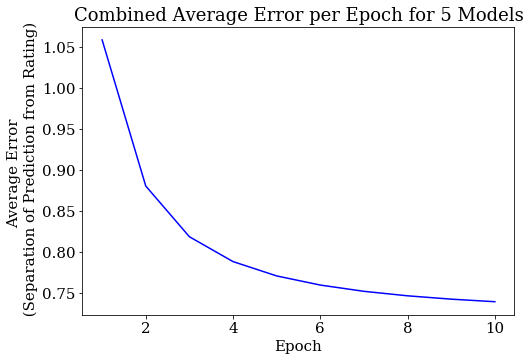

In [244]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 15
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
test, = ax.plot(range(1, epochs+1), crossval_avgerr, color = 'blue')
ax.set_title('Combined Average Error per Epoch for 5 Models')
ax.set_xlabel('Epoch')
ax.set_ylabel('Average Error \n (Separation of Prediction from Rating)')